In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata

import torch

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
raw_fp='/home/ngrav/project/wearables/data/raw/MOD1000WomanActivityData20210707T213505Z-001/MOD 1000 Woman Activity Data/'
raw_md_fp='/home/ngrav/project/wearables/data/raw/MOD_Data_2021.csv'
raw_md = pd.read_csv(raw_md_fp, low_memory=False)

In [3]:
raw_md.head()

,record_id,redcap_event_name,redcap_survey_identifier,customid,refused_future_research___1,refused_future_research___2,refused_future_research___3,reader,reader_text,age_enroll,...,edinb3_3trim,edinb4_3trim,edinb5_3trim,edinb6_3trim,edinb7_3trim,edinb8_3trim,edinb9_3trim,edinb10_3trim,edinburgh_check_trim3___1,third_edinburgh_depression_scale_complete
0,4,general_arm_1,NaN,4,0,0,0,7.0,Kristi,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,6,general_arm_1,NaN,6,0,0,0,4.0,NaN,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,9,general_arm_1,NaN,9,0,0,0,4.0,NaN,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,10,general_arm_1,NaN,10,0,0,0,4.0,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,21,general_arm_1,NaN,21,0,0,0,4.0,NaN,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [19]:
# import voi
from wearables.data.processed import md_pp_specification as md_rules
voi = md_rules.voi

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_enroll', ylabel='Density'>

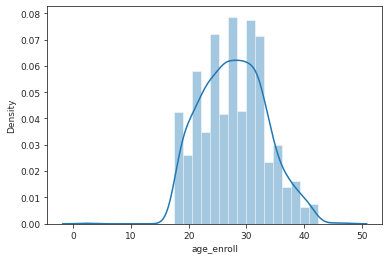

In [12]:
sns.distplot(raw_md['age_enroll'])

In [125]:
dt = raw_md.loc[raw_md['record_id']==1001, :]

In [131]:
dt.shape[0] 

(1, 3081)

In [129]:
labels = {col: dt.iloc[0, j] for j, col in enumerate(dt.columns)}

In [126]:
labels = {}
for j, col in enumerate(dt.columns):
    labels[col] = dt.iloc[0, j]

In [122]:
def inspect_tabular(voi, tab, figsize=(36, 24), n_subplots=[11, 10], verbose=False, plot_out=None, summary_out=None):
    '''
    
    Arguments:
      voi (dict): variables of interest as dictionary with 
        format: key=var name in column of df,
        value=([list of filters], continuous/categorical/ordinal) where 
        list of filters are triggered by a separate function later, and the second
        element of the tuple is a specification for the var type to be transformed.
      
    '''
    fig = plt.figure(figsize=figsize)
    summary = pd.DataFrame()
    from scipy.stats import normaltest
    for i, (k, v) in enumerate(voi.items()):
        ax = fig.add_subplot(n_subplots[1], n_subplots[0], i+1)
        if v[1] == 'continuous':
            statistic, p = normaltest(tab[k])
            if p < 0.01:
                central_summary = '{:.2f}'.format(tab[k].median())
                spread = ' ({:.2f} - {:.2f})'.format(tab[k].quantile(0.25), tab[k].quantile(0.75))
            else:
                central_summary = '{:.2f}'.format(tab[k].mean())
                spread = ' ({:.2f})'.format(tab[k].std())
                
            # calculate outliers
            IQR = tab[k].quantile(0.75) - tab[k].quantile(0.25)
            lo_bar = tab[k].median() - 1.5*IQR
            hi_bar = tab[k].median() + 1.5*IQR
            
            value_props = tab[k].loc[(tab[k] > hi_bar) | (tab[k] < lo_bar)].to_list() # could save fit kernle from distplot?
                
            
            if verbose:
                print(k, ':')
                print('  p_nan: {:.2f}'.format(tab[k].isna().sum()/tab.shape[0]))
                print('  outliers: ', np.unique(value_props))
                      
            # add distplot
            sns.distplot(tab[k], label=central_summary+spread, ax=ax)
            ax.legend()
            ax.set_xlabel('') # replace with title
            ax.set_title(k)
        
        elif v[1] == 'categorical':
            
            dt = raw_md[k].value_counts(normalize=True, dropna=False).reset_index()
            dt['index'] = dt['index'].astype(str) # force nan to show up on plot
            value_props = dt.to_dict()
                      
            if verbose:
                print(k, ':')
                print('  p_nan: {:.2f}'.format(tab[k].isna().sum()/tab.shape[0]))
                print('  value_props: ', np.unique(value_props))
            
            # add barplot 
            sns.barplot(x='index', y=k, data=dt, ax=ax)
            ax.set_ylabel('Proportion')
            ax.set_xlabel('')
            ax.set_title(k)
        
        else:
            raise NotImplementedError
            print('Variable could not be processed as instructions for {} not implemented.'.format(v[1]))
            
        fig.tight_layout()
        # store data
        dtt = pd.DataFrame({'Variable':k, 
                            'Type':v[1],
                            'value_props_OR_outliers':None, 
                            'p_nan':tab[k].isna().sum()/tab.shape[0]}, 
                           index=[0])
        dtt.at[0, 'value_props_OR_outliers'] = value_props
        summary = summary.append(dtt, ignore_index=True)
        
        if plot_out is not None:
            fig.savefig(plot_out, dpi=600, bbox_inches='tight')
            
        if summary_out is not None:
            summary.to_csv(summary_out)
            
    return summary
            
                

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

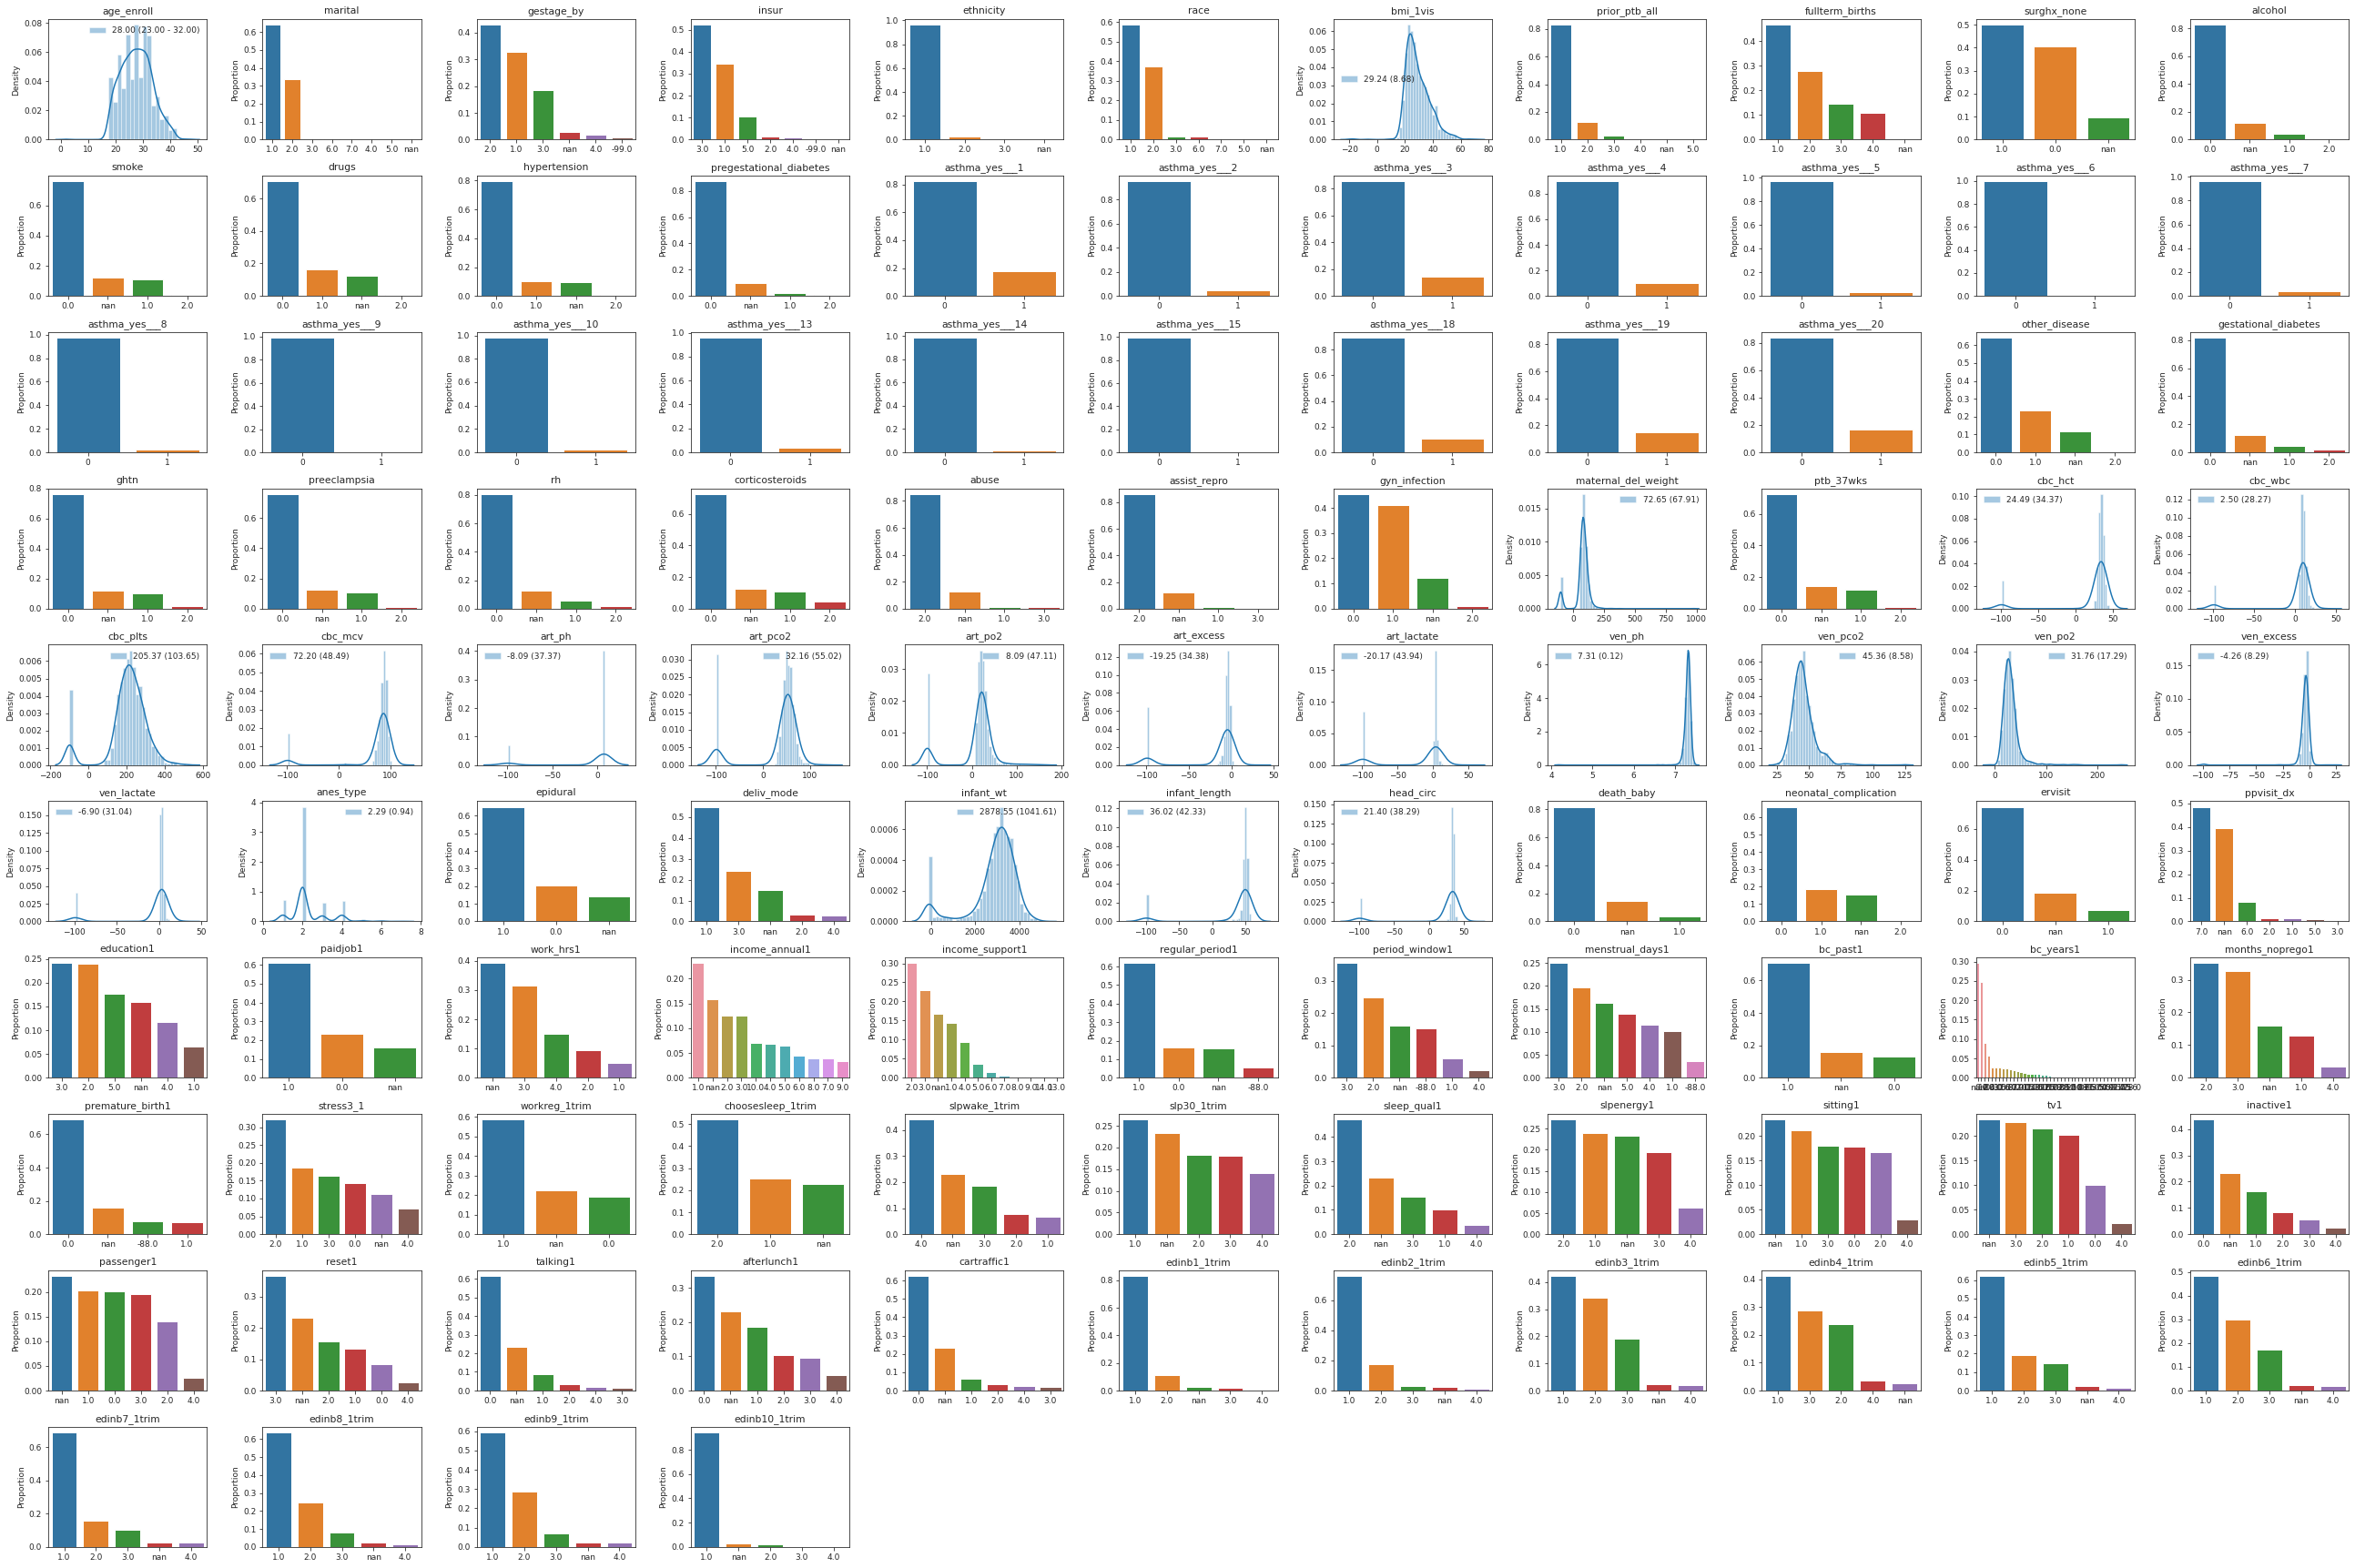

In [69]:
res = inspect_tabular(voi, raw_md, plot_out='/home/ngrav/project/wearables/results/md_var_summary_pre.pdf')

In [115]:
k = 'maternal_del_weight'
res.loc[res['Variable']==k, :]

,Variable,Type,value_props_OR_outliers,p_nan
40,maternal_del_weight,continuous,"[-99.0, -99.0, -99.0, -99.0, 152.4, 163.3, 148...",0.12859


In [107]:
# chk on value_counts
k = 'marital'
pd.DataFrame(res.loc[res['Variable']==k, 'value_props_OR_outliers'].item())

,index,marital
0,1.0,0.639034
1,2.0,0.336815
2,3.0,0.008486
3,6.0,0.006527
4,7.0,0.003916
5,4.0,0.003264
6,5.0,0.001305
7,nan,0.000653


In [114]:
dt = res.loc[res['Type']=='continuous', :].reset_index()
for i in range(dt.shape[0]):
    print('{}: '.format(dt.loc[i, 'Variable']), np.sort(dt.loc[i, 'value_props_OR_outliers']))

age_enroll:  [ 2 42 42 42 42 45 47]
bmi_1vis:  [-19.9933927  -17.53514739 -16.47266272  -7.1010101    8.63799622
  10.48372191  43.8917794   44.07685207  44.13277778  44.42237339
  44.6380117   44.78903988  44.86547291  45.2031893   45.24818597
  45.25822485  45.28507805  45.48217773  45.53772112  45.55943526
  45.64452003  45.67240588  45.69765684  45.82543945  45.89249181
  45.94886111  46.16870117  46.25656805  46.87296426  46.92387695
  47.00078044  47.13843787  47.25491124  47.39847745  47.4525
  47.6408216   47.67359963  47.80546306  47.88500977  47.96874496
  48.08210159  48.21035497  48.5860355   49.0852071   49.0984127
  49.25865052  49.31492537  49.33058588  49.41252441  49.4296875
  49.77553035  50.17084775  50.51400367  50.58272189  50.58272189
  50.81127778  51.20707596  51.40231401  51.91384615  52.12786961
  52.13916667  52.61636657  52.86169444  53.17223482  53.23493249
  53.27177778  53.85195378  54.13237305  54.7092071   54.87144169
  55.09367215  55.23081055  55.4748

In [77]:
raw_md.loc[raw_md['record_id']==1001, :]

,record_id,redcap_event_name,redcap_survey_identifier,customid,refused_future_research___1,refused_future_research___2,refused_future_research___3,reader,reader_text,age_enroll,...,edinb3_3trim,edinb4_3trim,edinb5_3trim,edinb6_3trim,edinb7_3trim,edinb8_3trim,edinb9_3trim,edinb10_3trim,edinburgh_check_trim3___1,third_edinburgh_depression_scale_complete
9,1001,general_arm_1,NaN,1001,0,0,0,6.0,NaN,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [120]:
# inspect
chk = {'': (None, 'continuous')}
inspect_tabular(chk, tab, figsize=(36, 24), n_subplots=[11, 10], verbose=True)

['depress_year_text2',
 'depress_details_text3',
 'art_excess',
 'art_excess_2',
 'ven_excess',
 'ven_excess_2',
 'stress1_1',
 'stress2_1',
 'stress3_1',
 'stress4_1',
 'stress5_1',
 'stress6_1',
 'stress7_1',
 'stress8_1',
 'stress9_1',
 'stress10_1',
 'tuesstart_1trim',
 'tuesstart_1trim2',
 'tuesstart_1trim3',
 'restless1',
 'restless_yes1',
 'restless_freq1',
 'ess_complete1',
 'businesstype1',
 'stress1_2',
 'stress2_2',
 'stress3_2',
 'stress4_2',
 'stress5_2',
 'stress6_2',
 'stress7_2',
 'stress8_2',
 'stress9_2',
 'stress10_2',
 'tuesstart_2trim',
 'tuesstart_2trim2',
 'tuesstart_2trim3',
 'restless2',
 'restless_yes2',
 'restless_freq2',
 'ess_complete2',
 'businesstype2',
 'stress1_3',
 'stress2_3',
 'stress3_3',
 'stress4_3',
 'stress5_3',
 'stress6_3',
 'stress7_3',
 'stress8_3',
 'stress9_3',
 'stress10_3',
 'tuesstart_3trim',
 'tuesstart_3trim2',
 'tuesstart_3trim3',
 'restless3',
 'restless_yes3',
 'restless_freq3',
 'ess_complete3',
 'businesstype3',
 'address1_date',